## Inside a Boiler - Slagging Prediction
#### https://opendata.edp.com/pages/challenges/#description

In [1]:
### Chec#from imblearn.combine import SMOTETomek
import pandas as pd 
import numpy as np 
from numpy import sort, sqrt, argsort, inf
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold

from sklearn.metrics import precision_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer, precision_recall_curve,confusion_matrix
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

In [2]:
modata = pd.read_csv('..\\data\\boiler_unity_xxx3.csv',sep=';')

### Check: hay variables de temperatura que, según la literatura, podrían ser altamente informativas?

In [3]:
temperature_columns_mask = ['temperature' in x for x in data.columns]
data.columns[temperature_columns_mask]


Index([], dtype='object')

### Eliminamos variables altamente correladas entre sí

In [4]:
import pandas_profiling

df_profile = pandas_profiling.ProfileReport(data)
df_profile.to_widgets()

### Check superficial de qué valores suelen encontrarse, para cierto atributo, en torno a las fechas previas a slag

In [5]:
Active_Power_mask = (data['Active_Power'] < 0.3) & (data['Active_Power'] > 0)
data[Active_Power_mask].SSTIMESTAMP.unique()

array(['14-04-xxx3 05:00:00', '14-04-xxx3 05:05:00',
       '14-04-xxx3 05:10:00', '14-04-xxx3 05:15:00',
       '14-04-xxx3 05:20:00', '14-04-xxx3 05:25:00',
       '14-04-xxx3 05:30:00', '14-04-xxx3 05:35:00',
       '14-04-xxx3 05:40:00', '14-04-xxx3 05:45:00',
       '15-04-xxx3 13:10:00', '15-04-xxx3 13:15:00',
       '15-04-xxx3 13:20:00', '20-04-xxx3 00:40:00',
       '20-04-xxx3 00:50:00', '20-04-xxx3 01:00:00',
       '20-04-xxx3 01:10:00', '20-04-xxx3 01:20:00',
       '20-04-xxx3 01:30:00', '20-04-xxx3 01:40:00',
       '20-04-xxx3 01:50:00', '20-04-xxx3 02:05:00',
       '20-04-xxx3 02:10:00', '20-04-xxx3 02:15:00',
       '20-04-xxx3 02:25:00', '20-04-xxx3 02:35:00',
       '20-04-xxx3 02:45:00', '20-04-xxx3 02:55:00',
       '20-04-xxx3 03:00:00', '20-04-xxx3 03:10:00',
       '20-04-xxx3 03:20:00', '20-04-xxx3 03:25:00',
       '20-04-xxx3 03:35:00', '20-04-xxx3 03:45:00',
       '20-04-xxx3 03:50:00', '20-04-xxx3 03:55:00',
       '20-04-xxx3 04:05:00', '20-04-xxx3 04:1

In [25]:
selected_colums_yisus = ['SSTIMESTAMP',
 'Active Power',
 'Boiler Furnace Pressure',
 'Boiler Outlet Pressure',
 'Coal Feeder #1',
 'Coal Feeder #5',
 'Cold Primary Air Control Damper Position @Coal Mill #1',
 'Cold Primary Air Control Damper Position @Coal Mill #2',
 'Cold Primary Air Control Damper Position @Coal Mill #3',
 'Cold Primary Air Control Damper Position @Coal Mill #4',
 'Cold Primary Air Control Damper Position @Coal Mill #5',
 'Hot Primary Air Control Damper Position @Coal Mill #1',
 'Hot Primary Air Control Damper Position @Coal Mill #2',
 'Hot Primary Air Control Damper Position @Coal Mill #3',
 'Hot Primary Air Control Damper Position @Coal Mill #4',
 'Hot Primary Air Control Damper Position @Coal Mill #5',
 'Dynamic Coal Classifier Rotational Speed Coal Mill #1',
 'Dynamic Coal Classifier Rotational Speed Coal Mill #2',
 'Dynamic Coal Classifier Rotational Speed Coal Mill #3',
 'Secondary Air Row #3 (Side 2)',
 'Secondary Air Row #5 (Side 2)',
 'Boosted Overfire Air (Side 1)',
 'Boosted Overfire Air (Side 2)',
 'Secondary Air Fan #1 Temperature 2',
 'Flue Gas Damper Position 1 (SH Side)',
 'Flue Gas Damper Position 2 (SH Side)',
 'Flue Gas Damper Position 1 (RH Side)',
 'Flue Gas Damper Position 2 (RH Side)',
 'Flue Gas Induced Draft Fan #1 Blade Pitch Angle',
 'Total Boiler Feedwater Flow',
 'Total Atemperator Feedwater Flow',
 'Main Steam First Desuperheater Control Valve position (Side 1)',
 'Main Steam First Desuperheater Control Valve position (Side 2)',
 'Main Steam Second Desuperheater Control Valve position (Side 1)',
 'Main Steam Second Desuperheater Control Valve position (Side 2)',
 'Main Steam Turbine Control Valve #B',
 'Main Steam Turbine Control Valve #D',
 'Emergency Reheated Steam Atemperation Valve Position',
 ]

In [6]:
'''
    En base a las correlaciones obtenidas en el profiling:
    - añado 'Boiler_Feedwater_Pressure'
    - elimino los cold primary air y me quedo con los hot primary air
    - añado 'Air Heater #1 Differential Pressure'
    - elimino 'Total_Boiler_Feedwater_Flow'
    - elimino los Flue gas damper position: por algo de experiencia, los valores que indican 
      posiciones de accionamientos no suelen informar de estados de procesos; además, el histograma de valores
      más anómalos (entre 0 y 10) no se dan en torno a las fechas de slag
    - 

'''

selected_colums_yirman = ['SSTIMESTAMP',
'Active_Power',
'Boiler_Feedwater_Pressure',
'Boiler_Furnace_Pressure',
'Boiler_Outlet_Pressure',
'Coal_Feeder_#1',
'Coal_Feeder_#5',
'Dynamic_Coal_Classifier_Rotational_Speed_Coal_Mill_#1',
'Dynamic_Coal_Classifier_Rotational_Speed_Coal_Mill_#2',
'Dynamic_Coal_Classifier_Rotational_Speed_Coal_Mill_#3',
'Secondary_Air_Row_#3_(Side_2)',
'Secondary_Air_Row_#5_(Side_2)',
'Boosted_Overfire_Air_(Side_1)',
'Boosted_Overfire_Air_(Side_2)',
'Secondary_Air_Fan_#1_Temperature_2',
'Flue_Gas_Induced_Draft_Fan_#1_Blade_Pitch_Angle',
'Total_Atemperator_Feedwater_Flow',
'Main_Steam_First_Desuperheater_Control_Valve_position_(Side_1)',
'Main_Steam_First_Desuperheater_Control_Valve_position_(Side_2)',
'Main_Steam_Second_Desuperheater_Control_Valve_position_(Side_1)',
'Main_Steam_Second_Desuperheater_Control_Valve_position_(Side_2)',
'Main_Steam_Turbine_Control_Valve_#B',
'Main_Steam_Turbine_Control_Valve_#D',
'Air_Heater_#1_Differential_Pressure',
'Reheated_Steam_Temperature_1_@Outlet']

data = data[selected_colums_yirman]

In [7]:
'''
data = data[selected_colums_yirman]
na_cols = [x for x in data.columns if x in data.columns[data.isnull().any()].tolist()]
for col in na_cols:
    data[col] = data[col].fillna(data[col].mean())
'''
#%%
def q10(x):
    return x.quantile(0.1)
def q20(x):
    return x.quantile(0.2)
def q30(x):
    return x.quantile(0.3)
def q40(x):
    return x.quantile(0.4)
def q50(x):
    return x.quantile(0.5)
def q60(x):
    return x.quantile(0.6)
def q70(x):
    return x.quantile(0.7)
def q80(x):
    return x.quantile(0.8)
def q90(x):
    return x.quantile(0.9)

### Para sampleo diario

In [500]:
'''
### Feature engineering: 
### 1.- en base a atributos estadísticos en sampleo diario
## ToDo:
### 2.- igual pero con otro sampling frequency
### 3.- añadiendo atributo de tendencias y/o estacionalidad
### 4.- TSFresh

unique_ID_values = data['ID'].unique()
unique_days = [x.split('-')[0] for x in unique_ID_values]
unique_months = [x.split('-')[1] for x in unique_ID_values]

tablon_final = pd.DataFrame({'ID': unique_ID_values, 'DAY': unique_days, 'MONTH': unique_months})
features = [x for x in data.columns if x not in ['TIME', 'HOUR', 'DAY', 'MONTH', 'ID']]
for col in features:
    #AÑADIR MEAN Y MEDIAN EXPONENTIALLY WEIGHTED
    prueba = data.groupby(['ID'])[col].agg(['count','mean','max','min','std','skew',q10]).reset_index(drop=True)
    prueba = prueba.add_prefix(col+'_')
    tablon_final = pd.concat([tablon_final, prueba],axis=1)
'''

"\n### Feature engineering: \n### 1.- en base a atributos estadísticos en sampleo diario\n## ToDo:\n### 2.- igual pero con otro sampling frequency\n### 3.- añadiendo atributo de tendencias y/o estacionalidad\n### 4.- TSFresh\n\nunique_ID_values = data['ID'].unique()\nunique_days = [x.split('-')[0] for x in unique_ID_values]\nunique_months = [x.split('-')[1] for x in unique_ID_values]\n\ntablon_final = pd.DataFrame({'ID': unique_ID_values, 'DAY': unique_days, 'MONTH': unique_months})\nfeatures = [x for x in data.columns if x not in ['TIME', 'HOUR', 'DAY', 'MONTH', 'ID']]\nfor col in features:\n    #AÑADIR MEAN Y MEDIAN EXPONENTIALLY WEIGHTED\n    prueba = data.groupby(['ID'])[col].agg(['count','mean','max','min','std','skew',q10]).reset_index(drop=True)\n    prueba = prueba.add_prefix(col+'_')\n    tablon_final = pd.concat([tablon_final, prueba],axis=1)\n"

### Para sampleo horario <font color='red'> (probar también con resampleo cada 4 horas por ejemplo) </font>

In [8]:

data['SSTIMESTAMP'][:3]

0    14-04-xxx3 05:00:00
1    14-04-xxx3 05:05:00
2    14-04-xxx3 05:10:00
Name: SSTIMESTAMP, dtype: object

### Creamos atributo ID con la combinación de mes+día+hora

In [9]:
datetime_values = data['SSTIMESTAMP']
hours_values = pd.Series([x.split(' ')[1].split(':')[0] for x in datetime_values]) 
days_values = pd.Series([x.split(' ')[0].split('-')[0] for x in datetime_values])
months_values = pd.Series([x.split(' ')[0].split('-')[1] for x in datetime_values])

frequency_sampling_ID = list([months_values[0]+'-'+days_values[0]+'-'+hours_values[0]])
for index in range(1, len(hours_values)):
    frequency_sampling_ID.append(months_values[index]+'-'+days_values[index]+'-'+hours_values[index])
data['ID_sampling'] = frequency_sampling_ID 

### Check: cada agrupación por ID_sampling debe contener 12 elementos (12 packs de 5 min por hora)

In [10]:
data.groupby(['ID_sampling'])['SSTIMESTAMP'].agg(['count'])

,count
ID_sampling,
01-01-00,12
01-01-01,12
01-01-02,12
01-01-03,12
01-01-04,12
...,...
12-31-19,12
12-31-20,12
12-31-21,12


In [11]:
data.head(5)
data.tail(5)

,SSTIMESTAMP,Active_Power,Boiler_Feedwater_Pressure,Boiler_Furnace_Pressure,Boiler_Outlet_Pressure,Coal_Feeder_#1,Coal_Feeder_#5,Dynamic_Coal_Classifier_Rotational_Speed_Coal_Mill_#1,Dynamic_Coal_Classifier_Rotational_Speed_Coal_Mill_#2,Dynamic_Coal_Classifier_Rotational_Speed_Coal_Mill_#3,...,Total_Atemperator_Feedwater_Flow,Main_Steam_First_Desuperheater_Control_Valve_position_(Side_1),Main_Steam_First_Desuperheater_Control_Valve_position_(Side_2),Main_Steam_Second_Desuperheater_Control_Valve_position_(Side_1),Main_Steam_Second_Desuperheater_Control_Valve_position_(Side_2),Main_Steam_Turbine_Control_Valve_#B,Main_Steam_Turbine_Control_Valve_#D,Air_Heater_#1_Differential_Pressure,Reheated_Steam_Temperature_1_@Outlet,ID_sampling
105403,31-12-xxx3 22:40:00,0.962110,207.4219,-1.406250,-7.343750,24.78516,23.75000,NaN,NaN,NaN,...,66.78659,37.67090,26.19629,0.927734,26.36719,90.63846,43.28142,8.660889,531.1395,12-31-22
105404,31-12-xxx3 22:50:00,0.962993,207.4219,-0.859375,-6.757813,24.59961,23.73047,NaN,NaN,NaN,...,63.19439,34.35059,26.19629,0.805664,25.63477,90.34306,42.77483,8.593750,531.1395,12-31-22
105405,31-12-xxx3 22:55:00,0.961610,207.6172,-1.464844,-7.167969,24.60938,23.58398,NaN,NaN,NaN,...,57.45774,26.73340,26.19629,2.001953,27.41699,90.63846,42.47087,8.459473,530.0515,12-31-22
105406,31-12-xxx3 23:00:00,0.957053,207.0313,-1.015625,-6.562500,25.06836,23.94531,NaN,NaN,NaN,...,55.36412,20.48340,26.19629,8.251953,36.05957,90.04764,40.95110,8.593750,530.0515,12-31-23
105407,31-12-xxx3 23:05:00,0.961544,207.0313,-1.113281,-6.777344,24.93164,23.84766,NaN,NaN,NaN,...,53.34284,18.72559,26.19629,6.469727,35.05859,91.22928,45.30779,8.666992,529.4993,12-31-23


### Statistical features engineering

In [12]:
### Feature engineering: 
### 1.- en base a atributos estadísticos en sampleo horario
## ToDo:
### 2.- igual pero con otro sampling frequency
### 3.- añadiendo atributo de tendencias y/o estacionalidad
### 4.- TSFresh

tablon_final = pd.DataFrame({'ID_sampling': frequency_sampling_ID, 'HOUR': hours_values, 'DAY': days_values, 'MONTH': months_values})
tablon_final.drop_duplicates(subset='ID_sampling', keep='first', inplace=True)
tablon_final.set_index('ID_sampling', inplace=True)

features = [x for x in data.columns if x not in ['ID_sampling', 'HOUR', 'DAY', 'MONTH', 'SSTIMESTAMP']]

for col in features:
    #AÑADIR MEAN Y MEDIAN EXPONENTIALLY WEIGHTED
    data_hourly_grouped = data.groupby(['ID_sampling'])[col].agg(['median','mean','max','min','std','skew',q10]).reset_index(drop=True)
    data_hourly_grouped = data_hourly_grouped.add_prefix(col+'_')
    data_hourly_grouped.index = tablon_final.index
    tablon_final = pd.concat([tablon_final, data_hourly_grouped],axis=1)


In [13]:
tablon_final.head(5)


,HOUR,DAY,MONTH,Active_Power_median,Active_Power_mean,Active_Power_max,Active_Power_min,Active_Power_std,Active_Power_skew,Active_Power_q10,...,Air_Heater_#1_Differential_Pressure_std,Air_Heater_#1_Differential_Pressure_skew,Air_Heater_#1_Differential_Pressure_q10,Reheated_Steam_Temperature_1_@Outlet_median,Reheated_Steam_Temperature_1_@Outlet_mean,Reheated_Steam_Temperature_1_@Outlet_max,Reheated_Steam_Temperature_1_@Outlet_min,Reheated_Steam_Temperature_1_@Outlet_std,Reheated_Steam_Temperature_1_@Outlet_skew,Reheated_Steam_Temperature_1_@Outlet_q10
ID_sampling,,,,,,,,,,,,,,,,,,,,,
04-14-05,05,14,04,0.971051,0.970274,0.973887,0.964101,0.002409,-1.447162,0.968512,...,0.054280,0.225260,14.247441,531.2882,531.288200,531.6591,530.9173,0.387392,0.000000,530.91730
04-14-06,06,14,04,0.969924,0.970403,0.974238,0.968576,0.001651,1.343561,0.968865,...,0.116722,1.615684,14.272461,530.6379,530.850550,531.6591,530.6379,0.404806,1.639243,530.63790
04-14-07,07,14,04,0.971687,0.971855,0.973722,0.970063,0.001249,0.182769,0.970486,...,0.236161,0.355408,13.709104,529.5507,529.917133,530.6379,529.5507,0.484254,0.763952,529.55070
04-14-08,08,14,04,0.915669,0.881347,0.961710,0.717774,0.078315,-1.447540,0.749869,...,1.149190,-1.667055,10.589596,529.4330,530.065167,536.3510,528.3726,2.110081,2.764497,528.66243
04-14-09,09,14,04,0.658643,0.625778,0.744070,0.511186,0.082686,-0.254622,0.513556,...,1.465079,0.775993,7.337036,534.6812,530.709058,536.2615,516.9485,6.744947,-1.258796,520.50139


## PLOTS

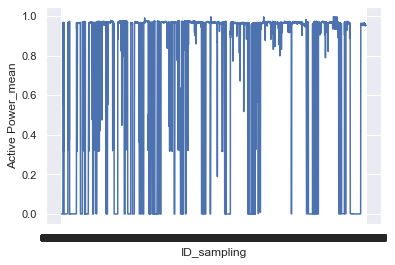

In [20]:
def plot_line_with_seaborn(dataset, x, y):
    import seaborn as sns; sns.set()
    import matplotlib.pyplot as plt

    ax = sns.lineplot(x=dataset.index, y=y, data=dataset)
    
plot_line_with_seaborn(dataset=tablon_final, x=tablon_final.index, y="Active Power_mean")

### Se añaden atributos temporales y se ordena por mes, día y hora

In [14]:
tablon_final.MONTH = tablon_final.MONTH.astype('int32')
tablon_final.DAY = tablon_final.DAY.astype('int32')
tablon_final.HOUR = tablon_final.HOUR.astype('int32')

tablon_final.sort_values(by=['MONTH', 'DAY', 'HOUR'], ascending=[1, 1, 1], inplace=True)

tablon_final.tail()

,HOUR,DAY,MONTH,Active_Power_median,Active_Power_mean,Active_Power_max,Active_Power_min,Active_Power_std,Active_Power_skew,Active_Power_q10,...,Air_Heater_#1_Differential_Pressure_std,Air_Heater_#1_Differential_Pressure_skew,Air_Heater_#1_Differential_Pressure_q10,Reheated_Steam_Temperature_1_@Outlet_median,Reheated_Steam_Temperature_1_@Outlet_mean,Reheated_Steam_Temperature_1_@Outlet_max,Reheated_Steam_Temperature_1_@Outlet_min,Reheated_Steam_Temperature_1_@Outlet_std,Reheated_Steam_Temperature_1_@Outlet_skew,Reheated_Steam_Temperature_1_@Outlet_q10
ID_sampling,,,,,,,,,,,,,,,,,,,,,
12-31-19,19,31,12,0.952722,0.952320,0.953785,0.950193,0.001114,-0.657970,0.950858,...,0.044355,-0.199619,9.436035,528.5209,528.096175,528.5209,526.7057,0.606076,-1.331748,527.34985
12-31-20,20,31,12,0.953476,0.953082,0.956220,0.951113,0.001545,0.374125,0.951216,...,0.017458,-3.356205,9.429932,529.2445,529.387733,530.9990,528.5209,0.744423,0.817317,528.52090
12-31-21,21,31,12,0.953203,0.953071,0.954170,0.951259,0.000944,-0.637840,0.951923,...,0.023900,2.109635,9.344482,530.4048,530.318492,530.9990,529.8615,0.323224,0.109726,529.86150
12-31-22,22,31,12,0.951875,0.952100,0.954699,0.950015,0.001456,0.363308,0.950471,...,0.030794,1.228296,9.387207,530.2122,530.306983,532.3994,527.6744,1.686662,-0.211472,527.87925
12-31-23,23,31,12,0.953463,0.953036,0.955259,0.949088,0.001961,-0.849123,0.950322,...,0.061496,-0.709394,9.264526,532.9197,533.077825,533.4312,532.7877,0.315543,0.314680,532.78770


## Añadimos los días que preceden al efecto de slag

In [15]:
### El resto de días no nos preocupa, ya que caeríamos dentro de los falsos positivos 
warning_window_dates = ['03-10', '04-10', '04-10', '05-10', '06-10', '07-10', '08-10', '09-10', '10-10',
                        '11-10', '12-10', '13-10', '14-10', '15-10', '16-10', '17-10', '18-10', '19-10',
                        '20-10', '21-10', '22-10', '23-10', '24-10', '25-10']

In [16]:
# el slagging day registrado para el boiler 3 en el año 3 es: 3-11-XXX3
slag_day_reference = 34 #(31 días de octubre + 3 de noviembre como referencia)
tablon_final['DAYS_TILL_SLAG'] = 0 

for date in warning_window_dates: 
    warning_month = int(date.split('-')[1])
    warning_day = int(date.split('-')[0])
    
    tablon_final['DAYS_TILL_SLAG'] = \
        np.where(((tablon_final.MONTH==warning_month)&(tablon_final.DAY==warning_day)),slag_day_reference-warning_day,
                   tablon_final['DAYS_TILL_SLAG'])


In [17]:
tablon_final[tablon_final.DAYS_TILL_SLAG>0]
tablon_final

,HOUR,DAY,MONTH,Active_Power_median,Active_Power_mean,Active_Power_max,Active_Power_min,Active_Power_std,Active_Power_skew,Active_Power_q10,...,Air_Heater_#1_Differential_Pressure_skew,Air_Heater_#1_Differential_Pressure_q10,Reheated_Steam_Temperature_1_@Outlet_median,Reheated_Steam_Temperature_1_@Outlet_mean,Reheated_Steam_Temperature_1_@Outlet_max,Reheated_Steam_Temperature_1_@Outlet_min,Reheated_Steam_Temperature_1_@Outlet_std,Reheated_Steam_Temperature_1_@Outlet_skew,Reheated_Steam_Temperature_1_@Outlet_q10,DAYS_TILL_SLAG
ID_sampling,,,,,,,,,,,,,,,,,,,,,
01-01-00,0,1,1,-0.000928,-0.000928,-0.000912,-0.000943,0.000010,0.000000,-0.000940,...,0.000000,-0.158691,74.25780,74.341773,74.78867,73.67287,0.316658,-1.246053e-01,74.25780,0
01-01-01,1,1,1,-0.000894,-0.000894,-0.000879,-0.000910,0.000010,0.000000,-0.000907,...,0.000000,-0.158691,73.40303,73.403030,73.67287,73.13319,0.281839,-9.078650e-14,73.13319,0
01-01-02,2,1,1,-0.000861,-0.000861,-0.000846,-0.000876,0.000010,0.000000,-0.000873,...,0.000000,-0.158691,72.59454,72.394597,72.59454,71.99471,0.295336,-8.124038e-01,71.99471,0
01-01-03,3,1,1,-0.000828,-0.000828,-0.000812,-0.000843,0.000010,0.000000,-0.000840,...,0.812404,-0.158691,71.41838,71.562462,71.99471,71.41838,0.260655,1.326650e+00,71.41838,0
01-01-04,4,1,1,-0.000800,-0.000800,-0.000790,-0.000810,0.000007,0.000000,-0.000808,...,0.000000,-0.146484,70.81923,70.612440,70.81923,70.19886,0.305449,-8.124038e-01,70.19886,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12-31-19,19,31,12,0.952722,0.952320,0.953785,0.950193,0.001114,-0.657970,0.950858,...,-0.199619,9.436035,528.52090,528.096175,528.52090,526.70570,0.606076,-1.331748e+00,527.34985,0
12-31-20,20,31,12,0.953476,0.953082,0.956220,0.951113,0.001545,0.374125,0.951216,...,-3.356205,9.429932,529.24450,529.387733,530.99900,528.52090,0.744423,8.173169e-01,528.52090,0
12-31-21,21,31,12,0.953203,0.953071,0.954170,0.951259,0.000944,-0.637840,0.951923,...,2.109635,9.344482,530.40480,530.318492,530.99900,529.86150,0.323224,1.097255e-01,529.86150,0


### Etiquetamos clases binarias. 

### Posteriormente, etiqutado multiclase para dar mayor relevancia en las predicciones de nuestros positivos (efecto slag) a los registros etiquetados como 4, luego 3... ya que nuestra hipótesis es que el efecto debe ser más evidente en días más próximos al efecto slag, y esto es más avanzados en nuestro warning window


In [18]:
tablon_final['TARGET'] = 0

mask_label = (tablon_final.DAYS_TILL_SLAG < 31)&(tablon_final.DAYS_TILL_SLAG >= 9)
mask_indexes = tablon_final[mask_label].index 
tablon_final.loc[mask_indexes, 'TARGET'] = 1
'''
mask_label = (tablon_final.DAYS_TILL_SLAG < 21)&(tablon_final.DAYS_TILL_SLAG > 8)
mask_indexes = tablon_final[mask_label].index 
tablon_final.loc[mask_indexes, 'TARGET'] = 2
'''

"\nmask_label = (tablon_final.DAYS_TILL_SLAG < 21)&(tablon_final.DAYS_TILL_SLAG > 8)\nmask_indexes = tablon_final[mask_label].index \ntablon_final.loc[mask_indexes, 'TARGET'] = 2\n"

In [19]:
tablon_final[tablon_final.TARGET>0][['MONTH', 'DAY', 'DAYS_TILL_SLAG', 'TARGET']]

,MONTH,DAY,DAYS_TILL_SLAG,TARGET
ID_sampling,,,,
10-04-00,10,4,30,1
10-04-01,10,4,30,1
10-04-02,10,4,30,1
10-04-03,10,4,30,1
10-04-04,10,4,30,1
...,...,...,...,...
10-25-19,10,25,9,1
10-25-20,10,25,9,1
10-25-21,10,25,9,1


### Construimos nuestro input attributes y el target

In [80]:
#inputs = [x for x in tablon_final.columns if x not in ['TARGET', 'DAYS_TILL_SLAG', 'HOUR', 'DAY', 'MONTH']]
inputs = [x for x in tablon_final.columns if x not in ['TARGET', 'HOUR', 'DAY', 'MONTH']]
X = tablon_final[inputs]
y = tablon_final['TARGET']

### Interpolamos valores ausentes: método lineal para datos de sensores

In [81]:
def imputeMissingInterpolating(array_df, features_to_impute):
    import numpy as np
    for attr in features_to_impute:
        attribute_interpolated = array_df[attr].interpolate(method='linear', limit_direction='both')
        #print('nans length for {}: {}'.format(attr, len(attribute_interpolated[np.isnan(attribute_interpolated)])))
        assert len(attribute_interpolated[np.isnan(attribute_interpolated)]) == 0
        
        array_df[attr] = attribute_interpolated
    
    return array_df

X_interpolated = imputeMissingInterpolating(X, X.columns[X.isna().any()])
X_interpolated.head(3)

,Active_Power_median,Active_Power_mean,Active_Power_max,Active_Power_min,Active_Power_std,Active_Power_skew,Active_Power_q10,Boiler_Feedwater_Pressure_median,Boiler_Feedwater_Pressure_mean,Boiler_Feedwater_Pressure_max,...,Air_Heater_#1_Differential_Pressure_skew,Air_Heater_#1_Differential_Pressure_q10,Reheated_Steam_Temperature_1_@Outlet_median,Reheated_Steam_Temperature_1_@Outlet_mean,Reheated_Steam_Temperature_1_@Outlet_max,Reheated_Steam_Temperature_1_@Outlet_min,Reheated_Steam_Temperature_1_@Outlet_std,Reheated_Steam_Temperature_1_@Outlet_skew,Reheated_Steam_Temperature_1_@Outlet_q10,DAYS_TILL_SLAG
ID_sampling,,,,,,,,,,,,,,,,,,,,,
01-01-00,-0.000928,-0.000928,-0.000912,-0.000943,0.00001,0.0,-0.000940,2.050781,2.050781,2.050781,...,0.0,-0.158691,74.25780,74.341773,74.78867,73.67287,0.316658,-1.246053e-01,74.25780,0
01-01-01,-0.000894,-0.000894,-0.000879,-0.000910,0.00001,0.0,-0.000907,2.050781,2.050781,2.050781,...,0.0,-0.158691,73.40303,73.403030,73.67287,73.13319,0.281839,-9.078650e-14,73.13319,0
01-01-02,-0.000861,-0.000861,-0.000846,-0.000876,0.00001,0.0,-0.000873,2.050781,2.050781,2.050781,...,0.0,-0.158691,72.59454,72.394597,72.59454,71.99471,0.295336,-8.124038e-01,71.99471,0


In [82]:
X_interpolated.columns[X_interpolated.isna().any()]

Index([], dtype='object')

### Escalamos valores estandarizando: standard scaler

In [83]:
def scale_and_save_scaler(dataframe, features_to_scale, df_to_concat, saving_path=False):
    try:
        import pandas as pd
        from sklearn.preprocessing import StandardScaler
        from joblib import dump

        #husillo m22
        standard_scaler = StandardScaler()
        standard_scaler.fit(dataframe[features_to_scale].values)
        scaled_dataframe_values = standard_scaler.transform(dataframe[features_to_scale].values)
        scaled_dataframe = pd.DataFrame(columns=features_to_scale, data=scaled_dataframe_values, index = dataframe.index)
        
        features_no_to_scale = [x for x in dataframe.columns if x not in features_to_scale]
        
        assert dataframe.index.all() == scaled_dataframe.index.all()
        
        final_scaled_df = pd.concat([df_to_concat, scaled_dataframe], axis=1) 
        
        if saving_path:
            dump(standard_scaler, saving_path) 

        return final_scaled_df

    except Exception as exc:
        print(exc)
        #return exc

numeric_features = [x for x in tablon_final.columns if x not in ['TARGET', 'DAYS_TILL_SLAG', 'HOUR', 'DAY', 'MONTH']]
dataset_to_concat = tablon_final[['TARGET', 'DAYS_TILL_SLAG', 'HOUR', 'DAY', 'MONTH']]
X_scaled_interpolated = scale_and_save_scaler(X_interpolated, features_to_scale = numeric_features, df_to_concat = dataset_to_concat)

In [84]:
X_scaled_interpolated.tail()

,TARGET,DAYS_TILL_SLAG,HOUR,DAY,MONTH,Active_Power_median,Active_Power_mean,Active_Power_max,Active_Power_min,Active_Power_std,...,Air_Heater_#1_Differential_Pressure_std,Air_Heater_#1_Differential_Pressure_skew,Air_Heater_#1_Differential_Pressure_q10,Reheated_Steam_Temperature_1_@Outlet_median,Reheated_Steam_Temperature_1_@Outlet_mean,Reheated_Steam_Temperature_1_@Outlet_max,Reheated_Steam_Temperature_1_@Outlet_min,Reheated_Steam_Temperature_1_@Outlet_std,Reheated_Steam_Temperature_1_@Outlet_skew,Reheated_Steam_Temperature_1_@Outlet_q10
ID_sampling,,,,,,,,,,,,,,,,,,,,,
12-31-19,0,0,19,31,12,0.637572,0.637506,0.615937,0.655620,-0.226944,...,-0.335827,-0.303348,0.342194,0.541193,0.538958,0.531702,0.540844,-0.188235,-1.380494,0.542270
12-31-20,0,0,20,31,12,0.639346,0.639302,0.621661,0.657786,-0.208970,...,-0.411670,-4.063219,0.340910,0.545244,0.546192,0.545572,0.551017,-0.139625,0.892677,0.548832
12-31-21,0,0,21,31,12,0.638703,0.639275,0.616844,0.658129,-0.234031,...,-0.393506,2.447248,0.322945,0.551742,0.551405,0.545572,0.558530,-0.287620,0.144223,0.556343
12-31-22,0,0,22,31,12,0.635578,0.636989,0.618086,0.655200,-0.212693,...,-0.374067,1.397468,0.331928,0.550663,0.551340,0.553410,0.546273,0.191444,-0.195523,0.545237
12-31-23,0,0,23,31,12,0.639316,0.639193,0.619402,0.653019,-0.191618,...,-0.287492,-0.910551,0.306134,0.565824,0.566859,0.559186,0.574929,-0.290319,0.361013,0.572738


### Guardamos X_scaled_interpolated

In [86]:
X_scaled_interpolated.to_csv('../data/X_scaled_interpolated.csv')

In [2]:
X_scaled_interpolated_from_csv = pd.read_csv('../data/X_scaled_interpolated.csv')

In [3]:
X_scaled_interpolated_from_csv.set_index('ID_sampling', inplace=True)

In [4]:
X_scaled_interpolated_from_csv

,TARGET,DAYS_TILL_SLAG,HOUR,DAY,MONTH,Active_Power_median,Active_Power_mean,Active_Power_max,Active_Power_min,Active_Power_std,...,Air_Heater_#1_Differential_Pressure_std,Air_Heater_#1_Differential_Pressure_skew,Air_Heater_#1_Differential_Pressure_q10,Reheated_Steam_Temperature_1_@Outlet_median,Reheated_Steam_Temperature_1_@Outlet_mean,Reheated_Steam_Temperature_1_@Outlet_max,Reheated_Steam_Temperature_1_@Outlet_min,Reheated_Steam_Temperature_1_@Outlet_std,Reheated_Steam_Temperature_1_@Outlet_skew,Reheated_Steam_Temperature_1_@Outlet_q10
ID_sampling,,,,,,,,,,,,,,,,,,,,,
01-01-00,0,0,0,1,1,-1.606084,-1.608938,-1.627494,-1.583496,-0.272968,...,-0.460900,-0.065578,-1.675075,-2.002492,-2.002449,-2.007939,-1.998109,-0.289927,-0.103640,-1.996371
01-01-01,0,0,1,1,1,-1.606005,-1.608860,-1.627415,-1.583417,-0.272968,...,-0.460900,-0.065578,-1.675075,-2.007278,-2.007707,-2.014185,-2.001133,-0.302161,0.028161,-2.002672
01-01-02,0,0,2,1,1,-1.605927,-1.608781,-1.627337,-1.583339,-0.272968,...,-0.460900,-0.065578,-1.675075,-2.011805,-2.013355,-2.020220,-2.007514,-0.297418,-0.831158,-2.009051
01-01-03,0,0,3,1,1,-1.605848,-1.608702,-1.627259,-1.583260,-0.272968,...,-0.443952,0.902092,-1.675075,-2.018391,-2.018015,-2.023578,-2.010744,-0.309604,1.431423,-2.012280
01-01-04,0,0,4,1,1,-1.605783,-1.608637,-1.627206,-1.583181,-0.273111,...,-0.460900,-0.065578,-1.672509,-2.021746,-2.023336,-2.030157,-2.017578,-0.293865,-0.831158,-2.019113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12-31-19,0,0,19,31,12,0.637572,0.637506,0.615937,0.655620,-0.226944,...,-0.335827,-0.303348,0.342194,0.541193,0.538958,0.531702,0.540844,-0.188235,-1.380494,0.542270
12-31-20,0,0,20,31,12,0.639346,0.639302,0.621661,0.657786,-0.208970,...,-0.411670,-4.063219,0.340910,0.545244,0.546192,0.545572,0.551017,-0.139625,0.892677,0.548832
12-31-21,0,0,21,31,12,0.638703,0.639275,0.616844,0.658129,-0.234031,...,-0.393506,2.447248,0.322945,0.551742,0.551405,0.545572,0.558530,-0.287620,0.144223,0.556343


## Aquí aún no metemos atributos de tiempo (por posible estacionalidad)
### Mantenemos 'DAYS_TILL_SLAG' para usarlo en la validación

In [5]:
X_scaled_interpolated = X_scaled_interpolated_from_csv

numeric_features = [x for x in X_scaled_interpolated.columns if x not in ['TARGET', 'DAYS_TILL_SLAG', 'HOUR', 'DAY', 'MONTH']]


In [6]:
### Stratified train-test split
from sklearn.model_selection import train_test_split

features_to_train_no_temp = [x for x in X_scaled_interpolated.columns if x not in ['TARGET', 'HOUR', 'DAY', 'MONTH']]
X_train, X_test, y_train, y_test=train_test_split(X_scaled_interpolated[features_to_train_no_temp], 
                                                  X_scaled_interpolated['TARGET'], test_size=0.20, stratify=X_scaled_interpolated['TARGET'])


In [23]:
#CHECK: proporción de positivos en todo el set de datos = proporción en los datos de test
assert round((len(y_test[y_test==1])/len(y_test)), 2) == round((len(X_scaled_interpolated[X_scaled_interpolated['TARGET']==1])/len(X_scaled_interpolated['TARGET'])), 2)


### Esto nos hace ver la importancia de probar otro sampleo con el que tengamos más datos, a parte de probar el SMOTE para oversamplear; de hecho necesito los days until slag para la función de coste de EDP, y no puedo oversamplear (no puede generar ficticos days till slag, a priori) <font color='red'> Probar también con el parámetro 'scale_pos_weight' de XGBOOST para el desbalanceo </font> 

In [9]:
### Automatic Oversampling: check el valor añadido de esto VS no hacerlo
#smt_sample = SMOTETomek(sampling_strategy ="auto")

X_train_attributes = numeric_features 
X_test_attributes = numeric_features 

train_slagdays_to_concat = X_train['DAYS_TILL_SLAG']
test_slagdays_to_concat = X_test['DAYS_TILL_SLAG']
'''
X_smt, y_smt = smt_sample.fit_sample(X_train[X_train_attributes], y_train)
y_smt = pd.Series(y_smt)
dataframe_stage_2 = pd.DataFrame(data=X_smt, columns=list(X_train_attributes))
'''


'\nX_smt, y_smt = smt_sample.fit_sample(X_train[X_train_attributes], y_train)\ny_smt = pd.Series(y_smt)\ndataframe_stage_2 = pd.DataFrame(data=X_smt, columns=list(X_train_attributes))\n'

### EDP cost function to evaluate our training

In [24]:
global defined_model
global features_to_train_on
global n_folds

features_to_train_on = numeric_features
n_folds = 5
from xgboost import XGBClassifier
defined_model = XGBClassifier(objective="binary:logistic", random_state=42)


In [25]:
### EDP cost function version 1 (falta incluir el coste por FP fuera de warning window):
def return_true_positive_savings(days_until_slag_value, no_return_days=9, tp_repair_cost=350000):
    try:
        tp_savings = tp_repair_cost - ((30-days_until_slag_value)*(tp_repair_cost/(30-no_return_days)))
        
        return tp_savings

    except Exception as exc:
        return exc

 
def return_edp_cost_function(y_preds, y_true_values): 
    """
        True positives (TP) are slagging events that happened in one of the boilers, detected in the warning window 
        (6/12 to 30 days before the date that marks the event). The point of no-return depends on the intensity of the 
        slagging event: 12 days prior to high-intensity slagging events or 6 days prior to low-intensity slagging events. 
        If a slagging event is detected in the warning window but in the wrong boiler, it counts as a false positive. 
        True Positives are translated into savings, according to the following expression:

        False negatives (FN) are real slagging events that happened in one of the boilers that are not detected in the 
        warning window. False negatives are translated into repair and downtime costs.

        False positives (FP) are detections in a boiler where there is no slagging events in the next 30 days. False positives 
        are translated into unnecessary inspection costs.

        Check for the special cases
    """
    
    try:

        costs_dict = {'fp_cost': 19253, 'fn_cost': 350000}

        #true_predicted_tuples = pd.DataFrame({'y_true': y_true_values, 'y_predicted': y_predicted_values, 'days_till_slag': days_until_slag})
        
        #y_predicted_values = defined_model.predict(X_values)
        y_predicted_values = y_preds
        
        true_predicted_tuples = pd.DataFrame({'y_true': y_true_values, 'y_predicted': y_predicted_values, \
                                              'days_till_slag': days_until_slag})
        true_predicted_tuples = true_predicted_tuples.reset_index(drop=True)
        #true positives, false positives and false negatives number
        tp_savings = 0
        
        first_tp_detected = False

        while first_tp_detected==False:
            for index in true_predicted_tuples.index:
                # TRUE POSITIVE condition:
                if ((true_predicted_tuples.iloc[index]['y_true']==1)&(true_predicted_tuples.iloc[index]['y_predicted']==1)):
                    tp_savings += return_true_positive_savings(true_predicted_tuples.iloc[index]['days_till_slag'])
                break
            first_tp_detected = True
        
        fp_number = len(true_predicted_tuples[(true_predicted_tuples.y_true==0)&(true_predicted_tuples.y_predicted==1)])
        fn_number = len(true_predicted_tuples[(true_predicted_tuples.y_true==1)&(true_predicted_tuples.y_predicted==0)])

        final_cost =  ((costs_dict['fp_cost'])*fp_number) + ((costs_dict['fn_cost'])*fn_number) - tp_savings

        return final_cost

    except Exception as exc:
        return exc
    

### Test de la 'return_edp_cost_function' 
#### Coste esperado: asociado a falso positivo = 19253

In [26]:
y_poc_test_preds = [1]
y_poc_test_true_values = [0]
days_until_slag = [40]

assert return_edp_cost_function(y_poc_test_preds, y_poc_test_true_values) == 19253
print('PASSED')

PASSED


In [27]:
y_poc_test_preds = [1, 0]
y_poc_test_true_values = [0, 1]
days_until_slag = [40, 30]

assert return_edp_cost_function(y_poc_test_preds, y_poc_test_true_values) == 19253 + 350000
print('PASSED')

PASSED


In [28]:
tp_savings = 350000 - ((30-9)*(350000/(30-9)))
print('coste a obtener: ', 19253 + 350000 - tp_savings)

print('coste devuelto por return_edp_cost_function: ', return_edp_cost_function(y_poc_test_preds, y_poc_test_true_values))

coste a obtener:  369253.0
coste devuelto por return_edp_cost_function:  369253


### FIN DE TEST DE EDP COST FUNCTION

### Plot confusion matrix, fuente: http://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/

### Probamos a ajustar las predicciones según diferentes thresolds para cada clase

#### <font color='green'> Para binario, la idea es: <p>
    - que reduzcamos el número de falsos positivos estableciendo un threshold de decisión más alto para los días más alejados del slag (entre 31 y 15?)
    - que reduzcamos falsos negativos, relajando el threshold de decisión a días próximos al slag (< 15?)  
     </font>

#### <font color='green'> Para multiclase, la idea es que reduzcamos el número de falsos negativos, por lo que hacemos que el threshold de decisión para la clase mayoritario ' no slag' sea más exigente, no sólo el máximo </font>


In [17]:
def assign_prediction_to_binary_probas(clf_prediction_proba, days_till_slag, proba_threshold=0.7, days_till_slag_threshold=15):
    import numpy as np
    import pandas as pd
    
    if days_till_slag > days_till_slag_threshold:
        if clf_prediction_proba[1] > proba_threshold:
            return 1
        else: return 0
    else:
        return np.max(0.5, clf_prediction_proba[1])
    

def assign_prediction_to_multiclass_probas(clf_prediction_probas):
    import numpy as np
    import pandas as pd
    
    preds_df = pd.DataFrame({'preds_probas': clf_prediction_probas, 'class': list(range(0, len(clf_prediction_probas)))})
    if preds_df['preds_probas'][0] < 0.6:
        selected_proba = np.max(clf_prediction_probas[1:])
        final_prediction = preds_df[preds_df['preds_probas']==selected_proba]['class']
    else:
        final_prediction = preds_df[preds_df['preds_probas']==np.max(clf_prediction_probas)]['class']
    
    return final_prediction.values[0]

### Hemos definido nuestra función ahorro como la inversa del coste asociado a los errores de nuestras predicciones

In [84]:
def eval_metric_function_for_training_xgboost(y_preds, y_true_values): 
    try:
        costs_dict = {'fp_cost': 19253, 'fn_cost': 350000}

        y_predicted_values = y_preds

        true_predicted_tuples = pd.DataFrame({'y_true': y_true_values, 'y_predicted': y_predicted_values, \
                                              'days_till_slag': days_until_slag})
        

        true_predicted_tuples = true_predicted_tuples.reset_index(drop=True)
        #true positives, false positives and false negatives number
        tp_savings = 0
        
        first_tp_detected = False

        while first_tp_detected==False:
            for index in true_predicted_tuples.index:
                # TRUE POSITIVE condition:
                if ((true_predicted_tuples.iloc[index]['y_true']==1)&(true_predicted_tuples.iloc[index]['y_predicted']==1)):
                    tp_savings += return_true_positive_savings(true_predicted_tuples.iloc[index]['days_till_slag'])

                    print('tp_savings added: ', tp_savings)
                    
                break
            first_tp_detected = True
        
        fp_number = len(true_predicted_tuples[(true_predicted_tuples.y_true==0)&(true_predicted_tuples.y_predicted==1)])
        fn_number = len(true_predicted_tuples[(true_predicted_tuples.y_true==1)&(true_predicted_tuples.y_predicted==0)])

        final_edp_cost =  ((costs_dict['fp_cost'])*fp_number) + ((costs_dict['fn_cost'])*fn_number) - tp_savings

        return 'eval_metric_function_for_training_xgboost', final_edp_cost

    except Exception as exc:
        raise exc
   

In [85]:
def evaluate_model_with_slag_days(dataX, dataY):
    from tqdm import tqdm
    from sklearn.model_selection import KFold
    
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    k = 0
    for train_ix, test_ix in tqdm(kfold.split(dataX)):
        print('kfold {}'.format(k))
        
        # select rows for train and test
        trainX, trainY, testX, testY = dataX.iloc[train_ix], dataY.iloc[train_ix], dataX.iloc[test_ix], \
                                       dataY.iloc[test_ix]
        
        days_until_slag = testX['DAYS_TILL_SLAG'] 
        
        # fit model
        history = defined_model.fit(trainX[features_to_train_on], trainY, #early_stopping_rounds=10, 
                                    eval_metric=eval_metric_function_for_training_xgboost, # 'auc'
                                    eval_set=[(testX[features_to_train_on], testY)])                               
        # evaluate model
        y_preds = defined_model.predict(testX[features_to_train_on])
        
        #score = return_edp_cost_function(y_preds, testY) 
        ###########################################################
        costs_dict = {'fp_cost': 19253, 'fn_cost': 350000}
        
        y_true_values = testY
        true_predicted_tuples = pd.DataFrame({'y_true': y_true_values, 'y_predicted': y_preds, \
                                              'days_till_slag': days_until_slag})
        true_predicted_tuples = true_predicted_tuples.reset_index(drop=True)
        #true positives, false positives and false negatives number
        tp_savings = 0
        
        first_tp_detected = False

        while first_tp_detected==False:
            for index in true_predicted_tuples.index:
                # TRUE POSITIVE condition:
                if ((true_predicted_tuples.iloc[index]['y_true']==1)&(true_predicted_tuples.iloc[index]['y_predicted']==1)):
                    tp_savings += return_true_positive_savings(true_predicted_tuples.iloc[index]['days_till_slag'])
                break
            first_tp_detected = True
        
        fp_number = len(true_predicted_tuples[(true_predicted_tuples.y_true==0)&(true_predicted_tuples.y_predicted==1)])
        fn_number = len(true_predicted_tuples[(true_predicted_tuples.y_true==1)&(true_predicted_tuples.y_predicted==0)])

        final_cost =  ((costs_dict['fp_cost'])*fp_number) + ((costs_dict['fn_cost'])*fn_number) - tp_savings
        ##########################################################
        score = final_cost
        
        print('score en evaluate_model_with_slag_days', score)
        
        #print('> %.3f' % (acc * 100.0))
        # append scores
        scores.append(score)
        histories.append(history)
        
        k = k + 1
        
    return defined_model, scores, histories

In [86]:
### Hiperparam. con Bayesian optimization
from hyperopt import hp
from sklearn.model_selection import StratifiedKFold

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

def return_model_scores(params, dataX, dataY, n_folds=5):
    import numpy as np
    
    defined_model, edp_cost_scores, histories = evaluate_model_with_slag_days(dataX = dataX, dataY = dataY)
    return np.array(edp_cost_scores).mean()


param_space = {'max_depth' : hp.choice('max_depth', range(5, 30, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
    'n_estimators' : hp.choice('n_estimators', range(20, 205, 5)),
    'gamma' : hp.quniform('gamma', 0, 0.50, 0.01),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.01),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.01),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 0.2, 0.8)}

# DEFINO ESTAS VARIABLES GLOBALES AL NO METERLAS COMO PARAMS. DE ENTRADA EN EL BAYESIAN HYPERP.
dataX = X_train
dataY = y_train
assert len(X_train)==len(y_train)
n_folds=5

global best
best = 0
i = 0
def f(params):
    cost = return_model_scores(params, dataX, dataY, n_folds=5)  
    if i == 0:
        best = cost
    
    if cost < best:
        best = cost
        print('new best:', best, params)
    
    return {'loss': cost, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=10, trials=trials)

#%%
print ('best:')
print (best)


on_0-error:0.014235	validation_0-eval_metric_function_for_training_xgboost:0



 90%|█████████ | 9/10 [04:52<00:29, 29.99s/it, best loss: 5004655.4]

[82]	validation_0-error:0.014235	validation_0-eval_metric_function_for_training_xgboost:0



 90%|█████████ | 9/10 [04:52<00:29, 29.99s/it, best loss: 5004655.4]

[83]	validation_0-error:0.014235	validation_0-eval_metric_function_for_training_xgboost:0



 90%|█████████ | 9/10 [04:52<00:29, 29.99s/it, best loss: 5004655.4]

[84]	validation_0-error:0.014235	validation_0-eval_metric_function_for_training_xgboost:0



 90%|█████████ | 9/10 [04:52<00:29, 29.99s/it, best loss: 5004655.4]

[85]	validation_0-error:0.014235	validation_0-eval_metric_function_for_training_xgboost:0



 90%|█████████ | 9/10 [04:52<00:29, 29.99s/it, best loss: 5004655.4]

[86]	validation_0-error:0.014235	validation_0-eval_metric_function_for_training_xgboost:0



 90%|█████████ | 9/10 [04:53<00:29, 29.99s/it, best loss: 5004655.4]

[87]	validation_0-error:0.014947	va

validar con AUC y comparar costes

In [91]:
#best = {'colsample_bytree': 0.27, 'gamma': 0.23, 'learning_rate': 0.15, 'max_depth': 12, 'min_child_weight': 3.0, 'n_estimators': 35, 'scale_pos_weight': 0.5539778217188118, 'subsample': 0.79}

len(X_test['DAYS_TILL_SLAG'])

1757

In [100]:
best['objective'] = 'binary:logistic'
params= best
xgb = XGBClassifier(**params) #'multi:softprob')

X_test_attributes = [x for x in X_test.columns if x not in ['DAYS_TILL_SLAG']]

eval_set = [(X_test[X_test_attributes], y_test)]
global days_until_slag
days_until_slag = X_test['DAYS_TILL_SLAG']

xgb_best_params = xgb.fit(X_train[X_test_attributes], y_train, eval_metric=eval_metric_function_for_training_xgboost, eval_set=eval_set, verbose=True)        
              
best_params_xgb_predictions = xgb_best_params.predict(X_test[X_test_attributes])
print('with eval_metric = {}'.format('return_edp_savings_function'))
confusion_matrix(y_test, best_params_xgb_predictions)

[0]	validation_0-error:0.041548	validation_0-eval_metric_function_for_training_xgboost:0
[1]	validation_0-error:0.038702	validation_0-eval_metric_function_for_training_xgboost:0
[2]	validation_0-error:0.039841	validation_0-eval_metric_function_for_training_xgboost:0
[3]	validation_0-error:0.036426	validation_0-eval_metric_function_for_training_xgboost:0
[4]	validation_0-error:0.034718	validation_0-eval_metric_function_for_training_xgboost:0
[5]	validation_0-error:0.033011	validation_0-eval_metric_function_for_training_xgboost:0
[6]	validation_0-error:0.031303	validation_0-eval_metric_function_for_training_xgboost:0
[7]	validation_0-error:0.029027	validation_0-eval_metric_function_for_training_xgboost:0
[8]	validation_0-error:0.029027	validation_0-eval_metric_function_for_training_xgboost:0
[9]	validation_0-error:0.029596	validation_0-eval_metric_function_for_training_xgboost:0
[10]	validation_0-error:0.028458	validation_0-eval_metric_function_for_training_xgboost:0
[11]	validation_0-er

array([[1650,    1],
       [  28,   78]], dtype=int64)

In [101]:
global days_until_slag

days_until_slag = X_test['DAYS_TILL_SLAG']

return_edp_cost_function(best_params_xgb_predictions, y_test)

9819253

In [102]:
days_until_slag = X_test['DAYS_TILL_SLAG']

return_edp_cost_function(best_params_xgb_predictions, y_test)

9819253

In [96]:
best_params_eval_results_df = pd.DataFrame({'y_true_values': y_test, 'y_predicted_values': best_params_xgb_predictions})
best_params_eval_results_df[best_params_eval_results_df.y_true_values==1]


,y_true_values,y_predicted_values
ID_sampling,,
10-09-13,1,1
10-16-15,1,1
10-20-19,1,1
10-16-00,1,1
10-15-20,1,1
...,...,...
10-04-18,1,1
10-18-17,1,1
10-11-19,1,0


In [97]:
best_params_eval_results_df[best_params_eval_results_df.y_predicted_values==1].index

Index(['10-09-13', '10-16-15', '10-20-19', '10-16-00', '10-15-20', '10-11-22',
       '10-14-07', '10-09-18', '10-23-07', '10-05-07', '10-06-08', '10-15-19',
       '10-14-00', '10-21-01', '10-07-02', '10-10-12', '10-07-04', '10-06-04',
       '10-16-20', '10-09-09', '10-25-01', '10-13-18', '10-11-06', '10-06-10',
       '10-06-05', '10-23-02', '10-15-13', '10-05-20', '10-22-02', '10-17-15',
       '10-25-02', '10-22-16', '10-22-17', '10-13-17', '10-13-21', '10-14-16',
       '10-07-16', '10-20-14', '10-04-14', '10-25-03', '10-19-12', '10-24-21',
       '10-23-15', '10-16-05', '10-15-22', '10-12-22', '10-18-23', '10-04-13',
       '10-10-00', '10-18-10', '10-14-10', '10-06-22', '10-25-12', '10-22-08',
       '11-19-07', '10-17-08', '10-19-06', '10-07-10', '10-23-06', '10-11-03',
       '10-20-09', '10-22-05', '10-13-16', '10-12-01', '10-19-21', '10-21-16',
       '10-19-23', '10-18-19', '10-18-03', '10-17-09', '10-06-17', '10-20-11',
       '10-08-00', '10-22-01', '10-09-03', '10-23-23

In [98]:
best_params_eval_results_df[best_params_eval_results_df.y_predicted_values==0].index

Index(['03-19-05', '05-25-00', '07-18-22', '02-23-13', '01-02-20', '06-07-00',
       '01-28-05', '05-15-11', '08-26-14', '03-09-00',
       ...
       '01-22-09', '07-24-22', '04-27-12', '06-27-02', '09-22-23', '05-16-01',
       '01-10-02', '08-15-12', '01-01-01', '02-02-08'],
      dtype='object', name='ID_sampling', length=1678)

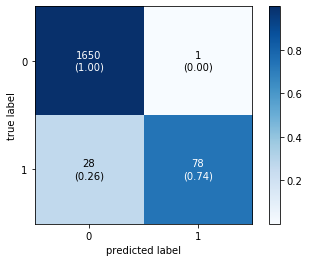

In [99]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, best_params_eval_results_df.y_predicted_values),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)

# Almacenamos el modelo predictor clasificador

In [103]:
import pickle

file_data = r'..\models\xgb_best_params.pkl'
file_data = open(file_data, 'wb')
pickle.dump(xgb_best_params, file_data)
file_data.close()

# Creo función que me convierta las predicciones horarias a predicciones diarias

In [109]:
preds_probas_df = pd.DataFrame({'y_true_values': y_test, 'y_predicted_values': xgb_best_params.predict(X_test[X_test_attributes]), 'y_predicted_probas': xgb_best_params.predict_proba(X_test[X_test_attributes])[:, 1]})
positive_preds_probas_df = preds_probas_df[preds_probas_df.y_predicted_values==1]
positive_preds_probas_df


,y_true_values,y_predicted_values,y_predicted_probas
ID_sampling,,,
10-09-13,1,1,0.740989
10-16-15,1,1,0.661393
10-20-19,1,1,0.942816
10-16-00,1,1,0.954159
10-15-20,1,1,0.899907
...,...,...,...
10-09-03,1,1,0.974046
10-23-23,1,1,0.990285
10-04-18,1,1,0.876443


## Plot de la distribución de probabilidades de nuestro clasificador

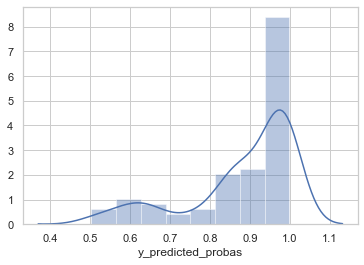

In [113]:
import seaborn as sns
sns.set(style="whitegrid")

ax = sns.distplot(positive_preds_probas_df.y_predicted_probas)

## La idea es predecir slag en el primer día que encontremos cuyo valor mediano (de entre los 24 registros horarios que tenga) de las probabilidades sea superior a un umbral definido, que según la distribución anterior podríamos situar en 0.8 por ej

In [114]:
positive_preds_probas_df[positive_preds_probas_df.y_predicted_probas < 0.8]

,y_true_values,y_predicted_values,y_predicted_probas
ID_sampling,,,
10-09-13,1,1,0.740989
10-16-15,1,1,0.661393
10-09-18,1,1,0.598101
10-10-12,1,1,0.670958
10-23-02,1,1,0.748978
10-22-16,1,1,0.797807
10-22-17,1,1,0.614599
10-13-21,1,1,0.648589
10-14-16,1,1,0.522399


In [121]:
unique_ID_values = positive_preds_probas_df.index
unique_days = [x.split('-')[1] for x in unique_ID_values]
unique_months = [x.split('-')[0] for x in unique_ID_values]

positive_preds_probas_df['month'] = unique_months
positive_preds_probas_df['day'] = unique_days

daily_median_pred_probs = positive_preds_probas_df.groupby(['month', 'day'])['y_predicted_probas'].agg(['median']) #.reset_index(drop=True)
daily_median_pred_probs_df = pd.DataFrame(daily_median_pred_probs)


In [133]:
daily_median_pred_probs_df.sort_values(by=['month', 'day'], axis='index')

median  string_index
month day                        
10    04   0.928751  ('10', '04')
      05   0.935107  ('10', '05')
      06   0.980386  ('10', '06')
      07   0.879425  ('10', '07')
      08   0.855319  ('10', '08')
      09   0.857518  ('10', '09')
      10   0.824051  ('10', '10')
      11   0.884215  ('10', '11')
      12   0.664117  ('10', '12')
      13   0.860516  ('10', '13')
      14   0.873224  ('10', '14')
      15   0.887596  ('10', '15')
      16   0.807776  ('10', '16')
      17   0.996528  ('10', '17')
      18   0.894626  ('10', '18')
      19   0.964004  ('10', '19')
      20   0.992149  ('10', '20')
      21   0.933902  ('10', '21')
      22   0.724713  ('10', '22')
      23   0.847843  ('10', '23')
      24   0.987081  ('10', '24')
      25   0.990285  ('10', '25')
11    19   0.805271  ('11', '19')

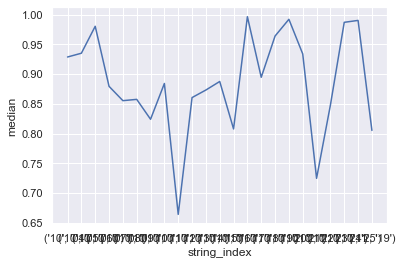

In [134]:
daily_median_pred_probs_df
daily_median_pred_probs_df.index

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

daily_median_pred_probs_df['string_index'] = [str(x) for x in daily_median_pred_probs_df.index]
ax = sns.lineplot(x='string_index', y="median", data=daily_median_pred_probs_df.sort_values(by=['month', 'day'], axis='index'))

# Por ahora mapearé probs > 0.85 como días slag

## Pruebo un modelo con otros hiperparams aleatorios para validar que los resultados son buenos:

In [ ]:
random_params = {'colsample_bytree': 0.95, 'gamma': 1, 'learning_rate': 0.15, 'max_depth': 2, 'min_child_weight': 3.0, 'n_estimators': 35, 'scale_pos_weight': 0.5539778217188118, 'subsample': 0.79}
random_params['objective'] = 'binary:logistic'
params= best
xgb_random_params = XGBClassifier(**random_params) #'multi:softprob')

X_test_attributes = [x for x in X_test.columns if x not in ['DAYS_TILL_SLAG']]

eval_set = [(X_test[X_test_attributes], y_test)]

xgb_random_params = xgb_random_params.fit(X_train[X_test_attributes], y_train, eval_metric=eval_metric_function_for_training_xgboost, eval_set=eval_set, verbose=True)              #eval_metric_function_for_training_xgboost, #'auc', 
              
xgb_random_params_xgb_predictions = xgb_random_params.predict(X_test[X_test_attributes])
print('with eval_metric = {}'.format('return_edp_savings_function'))
confusion_matrix(y_test, xgb_random_params_xgb_predictions)

In [ ]:
xgb_rand_params_xgb_predictions_eval_results_df = pd.DataFrame({'y_true_values': y_test, 'y_predicted_values': xgb_random_params_xgb_predictions})
xgb_rand_params_xgb_predictions_eval_results_df[xgb_rand_params_xgb_predictions_eval_results_df.y_true_values==1]

In [ ]:
xgb_rand_params_xgb_predictions_eval_results_df[xgb_rand_params_xgb_predictions_eval_results_df.y_predicted_values==1].index

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, xgb_random_params_xgb_predictions),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)

## Confirmo que utilizando los best hiperparams de la hiperparam. bayesiana nos da mejor matriz de confusión (sobre todo, mejor ratio de verdaderos positivos)

# Repito entrenamientos con eval_metric = 'auc'

In [ ]:
def evaluate_model_with_slag_days(dataX, dataY):
    from tqdm import tqdm
    from sklearn.model_selection import KFold
    
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    k = 0
    for train_ix, test_ix in tqdm(kfold.split(dataX)):
        print('kfold {}'.format(k))
        
        # select rows for train and test
        trainX, trainY, testX, testY = dataX.iloc[train_ix], dataY.iloc[train_ix], dataX.iloc[test_ix], \
                                       dataY.iloc[test_ix]
        
        days_until_slag = testX['DAYS_TILL_SLAG'] #dataX.iloc[test_ix]['DAYS_TILL_SLAG']
        
        # fit model
        history = defined_model.fit(trainX[features_to_train_on], trainY, #early_stopping_rounds=10, 
                                    eval_metric='auc',   #eval_metric_function_for_training_xgboost
                                    eval_set=[(testX[features_to_train_on], testY)])                               
        # evaluate model
        y_preds = defined_model.predict(testX[features_to_train_on])
        
        #score = return_edp_cost_function(y_preds, testY) 
        ###########################################################
        costs_dict = {'fp_cost': 19253, 'fn_cost': 350000}
        
        #print('len(y_true_values): {}'.format(len(y_true_values)))
        #print('len(y_predicted_values): {}'.format(len(y_preds)))
        #print('len(days_until_slag): {}'.format(len(days_until_slag)))
        
        y_true_values = testY
        true_predicted_tuples = pd.DataFrame({'y_true': y_true_values, 'y_predicted': y_preds, \
                                              'days_till_slag': days_until_slag})
        true_predicted_tuples = true_predicted_tuples.reset_index(drop=True)
        #true positives, false positives and false negatives number
        tp_savings = 0
        
        first_tp_detected = False

        while first_tp_detected==False:
            for index in true_predicted_tuples.index:
                # TRUE POSITIVE condition:
                if ((true_predicted_tuples.iloc[index]['y_true']==1)&(true_predicted_tuples.iloc[index]['y_predicted']==1)):
                    tp_savings += return_true_positive_savings(true_predicted_tuples.iloc[index]['days_till_slag'])
                break
            first_tp_detected = True
        
        fp_number = len(true_predicted_tuples[(true_predicted_tuples.y_true==0)&(true_predicted_tuples.y_predicted==1)])
        fn_number = len(true_predicted_tuples[(true_predicted_tuples.y_true==1)&(true_predicted_tuples.y_predicted==0)])

        final_cost =  ((costs_dict['fp_cost'])*fp_number) + ((costs_dict['fn_cost'])*fn_number) - tp_savings
        ##########################################################
        score = final_cost
        
        print('score en evaluate_model_with_slag_days', score)
        
        #print('> %.3f' % (acc * 100.0))
        # append scores
        scores.append(score)
        histories.append(history)
        
        k = k + 1
        
    return defined_model, scores, histories

In [ ]:
### Hiperparam. con Bayesian optimization
from hyperopt import hp
from sklearn.model_selection import StratifiedKFold

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

def return_model_scores(params, dataX, dataY, n_folds=5):
    import numpy as np
    
    defined_model, edp_cost_scores, histories = evaluate_model_with_slag_days(dataX = dataX, dataY = dataY)   
    print(edp_cost_scores)
    return np.array(edp_cost_scores).mean()


param_space = {'max_depth' : hp.choice('max_depth', range(5, 30, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
    'n_estimators' : hp.choice('n_estimators', range(20, 205, 5)),
    'gamma' : hp.quniform('gamma', 0, 0.50, 0.01),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.01),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.01),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 0.2, 0.8)}

# DEFINO ESTAS VARIABLES GLOBALES AL NO METERLAS COMO PARAMS. DE ENTRADA EN EL BAYESIAN HYPERP.
dataX = X_train
dataY = y_train
assert len(X_train)==len(y_train)
n_folds=5

global best
best = 0
i = 0
def f(params):
    cost = return_model_scores(params, dataX, dataY, n_folds=5)  
    if i == 0:
        best = cost
    
    if cost < best:
        best = cost
        print('new best:', best, params)
    
    return {'loss': cost, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=10, trials=trials)

#%%
print ('best:')
print (best)


# COMPROBAR SI CUMPLE BIEN EL BREAK EN CASO DE DETECTAR POSITIVO A TIEMPO

## POC HIPEROPT: espero que simplemente encuentre el mínimo de las función de coste 'loss' x**2

In [ ]:
import pickle
import time
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

def objective(x):
    return {
        'loss': x ** 3,
        'status': STATUS_OK,
        # -- store other results like this
        'eval_time': time.time(),
        'other_stuff': {'type': None, 'value': [0, 1, 2]},
        # -- attachments are handled differently
        'attachments':
            {'time_module': pickle.dumps(time.time)}
        }
trials = Trials()
best = fmin(objective,
    space=hp.uniform('x', -3, 3),
    algo=tpe.suggest,
    max_evals=100,
    trials=trials)

print('with 100 trials: ', best)

trials = Trials()
best = fmin(objective,
    space=hp.uniform('x', -3, 3),
    algo=tpe.suggest,
    max_evals=1000,
    trials=trials)

print('with 1000 trials: ', best)

### <font color='green'> CHECKED: se minimiza correctamente el valor de x, que es el argumento de la función objetivo, al igual que en nuestro caso lo serán los hiperparams a optimizar, para la parábola en el dominio [-10, 10]

### Reentrenamos y evaluamos con los best params

In [ ]:
params=best
params['objective'] = 'multi:softprob'
from xgboost import XGBClassifier
xgb_last_clf = XGBClassifier(**params)

# %%
#clf = clf.fit(dataframe_stage_2,y_smt)
xgb_last_clf = xgb_last_clf.fit(dataframe_stage_2,y_smt, eval_metric=return_edp_cost_function, 
                                eval_set=eval_set, verbose=True)
                                
# %%
last_xgb_predictions = xgb_last_clf.predict(X_test[X_test_attributes])
confusion_matrix(y_test,last_xgb_predictions)

#%%[markdown]
### Edp cost:
last_xgb_edp_function_cost = return_edp_cost_function(xgb_last_clf, X_test[X_test_attributes], y_test)
print('EDP cost with edp cost evaluation metric: {}'.format(last_xgb_edp_function_cost))



In [ ]:
confusion_matrix(y_test, last_xgb_predictions)

In [ ]:
y_test

In [ ]:
last_xgb_predictions

In [ ]:
xgb_last_clf.predict_proba(X_test[X_test_attributes])

In [ ]:
def assign_prediction_to_proba(clf_prediction_proba):
    preds_dict = {'preds_probas': clf_prediction_proba, 'class': list(range(0, len(clf_prediction_proba)))}
    if preds_dict['preds_probas'][0] < 0.6:
        selected_proba = np.max(clf_prediction_proba[1:])
        final_prediction = preds_dict[preds_dict['preds_probas']==selected_proba]['class']
    
    return prediction

